  Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Mounted at /content/drive
Model sudah ada. Ingin melatih ulang? (ya/tidak): ya
🚀 Melatih model dari awal...
Epoch 1: Train Loss=38.4082, Val Loss=0.1199, Acc=0.9636, F1=0.9626
Epoch 2: Train Loss=25.4868, Val Loss=0.0965, Acc=0.9653, F1=0.9648
Epoch 3: Train Loss=24.2094, Val Loss=0.0889, Acc=0.9697, F1=0.9691
Epoch 4: Train Loss=23.9011, Val Loss=0.1073, Acc=0.9644, F1=0.9635
Epoch 5: Train Loss=24.2170, Val Loss=0.0979, Acc=0.9661, F1=0.9651
Epoch 6: Train Loss=19.2340, Val Loss=0.0853, Acc=0.9717, F1=0.9711
Epoch 7: Train Loss=19.2365, Val Loss=0.0797, Acc=0.9729, F1=0.9724
Epoch 8: Train Loss=16.9226, Val Loss=0.0803, Acc=0.9737, F1=0.9732
Epoch 9: Train Loss=16.0014, Val Loss=0.0786, Acc=0.9737, F1=0.9733
Epoch 10: Train Loss=14.5871, Val Loss=0.0744, Acc=0.9754, F1=0.9750


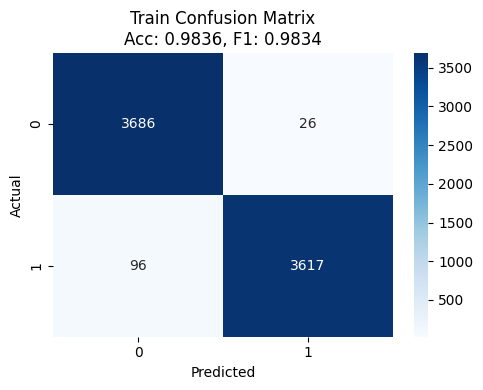

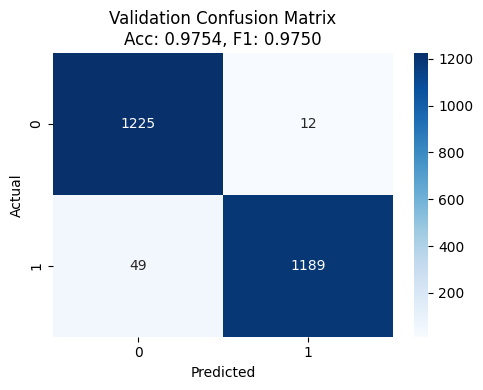

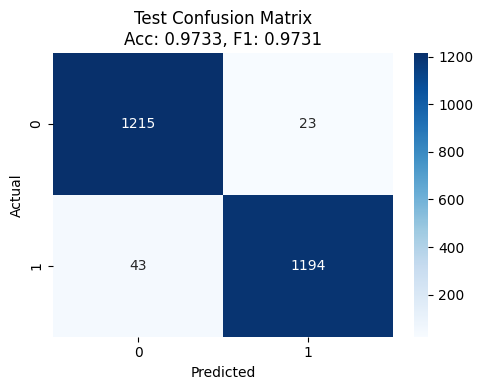

,Model,CPU Usage (%),RAM Usage (MB),Training Time (s),Inference Time (s),Model Size (MB),Accuracy,Precision,Recall,F1 Score
0,BiLSTM + Word2Vec (Only Text),63.7,267.09,84.33,1.95,0.23,0.973333,0.981101,0.965238,0.973105


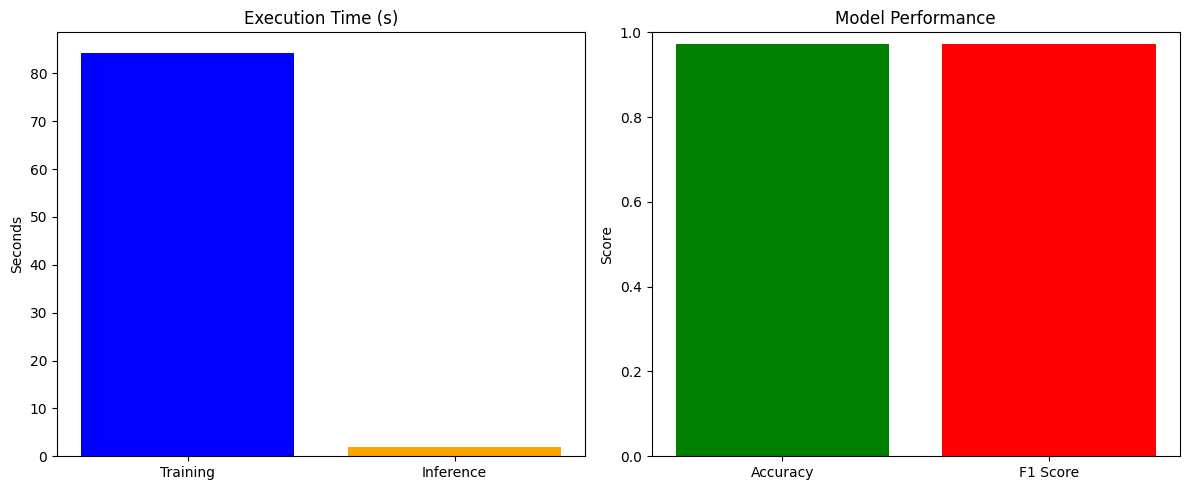

In [1]:
# ========================== [1] Install Library ==========================
!pip install --upgrade numpy gensim scikit-learn psutil torch torchvision

# ========================== [2] Import Library ==========================
import os, time, random, psutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn, optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from google.colab import drive

# ========================== [3] Seed & Mount ==========================
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
drive.mount('/content/drive')

# ========================== [4] Resource Monitoring & Plotting ==========================
def get_resource_usage():
    process = psutil.Process(os.getpid())
    cpu = psutil.cpu_percent(interval=None)
    ram = process.memory_info().rss / (1024 * 1024)
    return cpu, ram

def plot_execution_summary(log_df):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].bar(["Training", "Inference"],
              [log_df["Training Time (s)"].values[0], log_df["Inference Time (s)"].values[0]],
              color=["blue", "orange"])
    ax[0].set_title("Execution Time (s)")
    ax[0].set_ylabel("Seconds")

    ax[1].bar(["Accuracy", "F1 Score"],
              [log_df["Accuracy"].values[0], log_df["F1 Score"].values[0]],
              color=["green", "red"])
    ax[1].set_ylim(0, 1)
    ax[1].set_title("Model Performance")
    ax[1].set_ylabel("Score")

    plt.tight_layout()
    plt.show()

# ========================== [5] Load Dataset ==========================
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/3. Data Pre Processing/Dataset After Preprocessing/5. Plain Text Only.csv")
df.dropna(subset=["filename", "label", "plain_text_only"], inplace=True)
labels = np.array(df["label"].tolist(), dtype=np.int64)
plain_text_onlys = [str(text).split() for text in df["plain_text_only"]]

# ========================== [6] Train-Valid-Test Split ==========================
train_idx, temp_idx, y_train, y_temp = train_test_split(np.arange(len(df)), labels, test_size=0.4, stratify=labels, random_state=seed)
val_idx, test_idx, y_val, y_test = train_test_split(temp_idx, y_temp, test_size=0.5, stratify=y_temp, random_state=seed)
plain_text_onlys_train = [plain_text_onlys[i] for i in train_idx]
plain_text_onlys_val = [plain_text_onlys[i] for i in val_idx]
plain_text_onlys_test = [plain_text_onlys[i] for i in test_idx]

# ========================== [7] Train Word2Vec ==========================
embed_dim = 50
w2v_model = Word2Vec(sentences=plain_text_onlys_train, vector_size=embed_dim, window=2, min_count=1, workers=4)

# ========================== [8] Dataset & DataLoader ==========================
class TextDataset(Dataset):
    def __init__(self, plain_text_onlys, labels, w2v_model, embed_dim, max_len=128):
        self.texts = plain_text_onlys
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.w2v = w2v_model
        self.embed_dim = embed_dim
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        tokens = self.texts[idx][:self.max_len]
        vectors = [torch.tensor(self.w2v.wv[word], dtype=torch.float32) for word in tokens if word in self.w2v.wv]
        if len(vectors) == 0:
            vectors = [torch.zeros(self.embed_dim, dtype=torch.float32)]
        return torch.stack(vectors), self.labels[idx]

def collate_fn(batch):
    sequences, labels = zip(*batch)
    padded = pad_sequence(sequences, batch_first=True)
    label_tensor = torch.tensor(labels, dtype=torch.long)
    return padded, label_tensor

# ========================== [9] Model ==========================
class BiLSTMOnlyText(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, dropout=0.3):
        super(BiLSTMOnlyText, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x_seq):
        lstm_out, (hidden, _) = self.lstm(x_seq)
        hidden_cat = torch.cat((hidden[-2], hidden[-1]), dim=1)
        return self.fc(self.dropout(hidden_cat))

def get_model_size(model_path):
    size_bytes = os.path.getsize(model_path)
    size_mb = round(size_bytes / (1024 * 1024), 2)
    return size_mb
# ========================== [10] Loader & Training ==========================
batch_size = 32
train_dataset = TextDataset(plain_text_onlys_train, y_train, w2v_model, embed_dim)
val_dataset = TextDataset(plain_text_onlys_val, y_val, w2v_model, embed_dim)
test_dataset = TextDataset(plain_text_onlys_test, y_test, w2v_model, embed_dim)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

model_path = "/content/drive/My Drive/Colab Notebooks/5. Output/2. Biltstm + Word2Vec/Text Only/best_bilstm.pt"
os.makedirs(os.path.dirname(model_path), exist_ok=True)

model = BiLSTMOnlyText(embed_dim, hidden_dim=64, output_dim=2, dropout=0.4).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

retrain = input("Model sudah ada. Ingin melatih ulang? (ya/tidak): ").strip().lower()
start_time = time.time()
cpu_before, ram_before = get_resource_usage()

if os.path.exists(model_path) and retrain != "ya":
    print("✅ Model ditemukan. Melanjutkan ke evaluasi...")
    model.load_state_dict(torch.load(model_path))
else:
    print("🚀 Melatih model dari awal...")
    train_losses, val_losses = [], []
    best_val_loss = float('inf'); wait = 0; patience = 3

    for epoch in range(10):
        model.train()
        total_loss = 0
        for X_seq, y_batch in train_loader:
            X_seq, y_batch = X_seq.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_seq)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        val_loss = 0.0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for X_seq, y_batch in val_loader:
                X_seq, y_batch = X_seq.to(device), y_batch.to(device)
                outputs = model(X_seq)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y_batch.cpu().numpy())

        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)
        avg_val_loss = val_loss / len(val_loader)
        train_losses.append(total_loss)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}: Train Loss={total_loss:.4f}, Val Loss={avg_val_loss:.4f}, Acc={acc:.4f}, F1={f1:.4f}")
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            wait = 0
            torch.save(model.state_dict(), model_path)
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping")
                break

# ========================== [11] Evaluation ==========================
model.load_state_dict(torch.load(model_path))
model.eval()

cpu_after, ram_after = get_resource_usage()
end_time = time.time()

def evaluate_and_plot(loader, name):
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_seq, y_batch in loader:
            X_seq, y_batch = X_seq.to(device), y_batch.to(device)
            outputs = model(X_seq)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix\nAcc: {acc:.4f}, F1: {f1:.4f}")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()
    return acc, f1, precision, recall

evaluate_and_plot(train_loader, "Train")
evaluate_and_plot(val_loader, "Validation")
test_acc, test_f1, test_prec, test_rec = evaluate_and_plot(test_loader, "Test")

# ========================== [12] Logging & Visualisasi Akhir ==========================
start_infer = time.time()
with torch.no_grad():
    for X_seq, y_batch in test_loader:
        X_seq, y_batch = X_seq.to(device), y_batch.to(device)
        _ = model(X_seq)
end_infer = time.time()

log_df = pd.DataFrame([{
    "Model": "BiLSTM + Word2Vec (Only Text)",
    "CPU Usage (%)": cpu_after,
    "RAM Usage (MB)": round(ram_after - ram_before, 2),
    "Training Time (s)": round(end_time - start_time, 2),
    "Inference Time (s)": round(end_infer - start_infer, 2),
    "Model Size (MB)": get_model_size(model_path),
    "Accuracy": test_acc,
    "Precision": test_prec,
    "Recall": test_rec,
    "F1 Score": test_f1
}])

log_df.to_csv("/content/drive/My Drive/Colab Notebooks/5. Output/2. Biltstm + Word2Vec/Text Only/resource_log_bilstm.csv", index=False)
display(log_df)
plot_execution_summary(log_df)


  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Mounted at /content/drive
Model sudah ada. Ingin melatih ulang? (ya/tidak): ya
🚀 Melatih model dari awal...
Epoch 1: Train Loss=210.7910, Val Loss=0.1342, Acc=0.9604, F1=0.9596
Epoch 2: Train Loss=30.0696, Val Loss=0.1265, Acc=0.9604, F1=0.9590
Epoch 3: Train Loss=24.6404, Val Loss=0.1090, Acc=0.9677, F1=0.9671
Epoch 4: Train Loss=19.3012, Val Loss=0.0990, Acc=0.9697, F1=0.9692
Epoch 5: Train Loss=19.6381, Val Loss=0.0802, Acc=0.9754, F1=0.9751
Epoch 6: Train Loss=17.2306, Val Loss=0.0725, Acc=0.9749, F1=0.9745
Epoch 7: Train Loss=15.7886, Val Loss=0.0844, Acc=0.9681, F1=0.9672
Epoch 8: Train Loss=17.4175, Val Loss=0.1265, Acc=0.9568, F1=0.9576
Early stopping


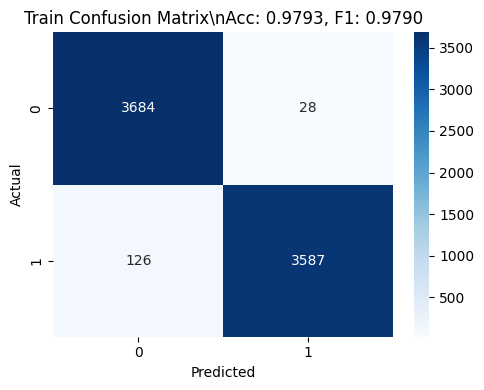

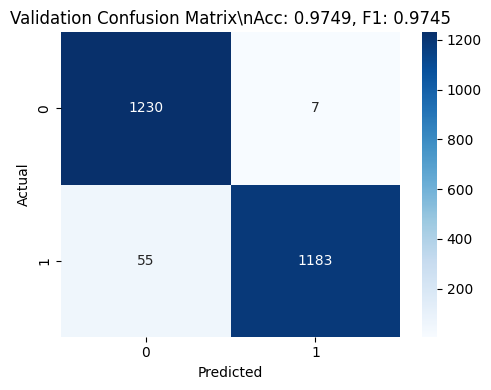

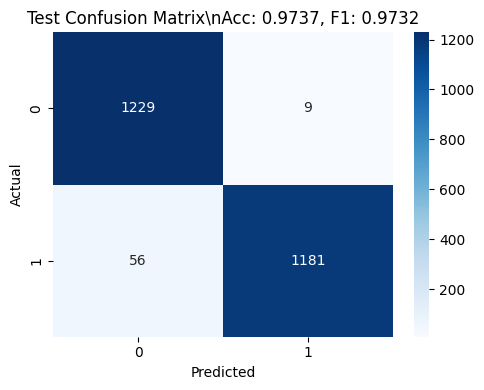

,Model,CPU Usage (%),RAM Usage (MB),Training Time (s),Inference Time (s),Accuracy,F1 Score
0,BiLSTM + Word2Vec + Numeric,63.9,275.96,144.6,3.54,0.973737,0.973218


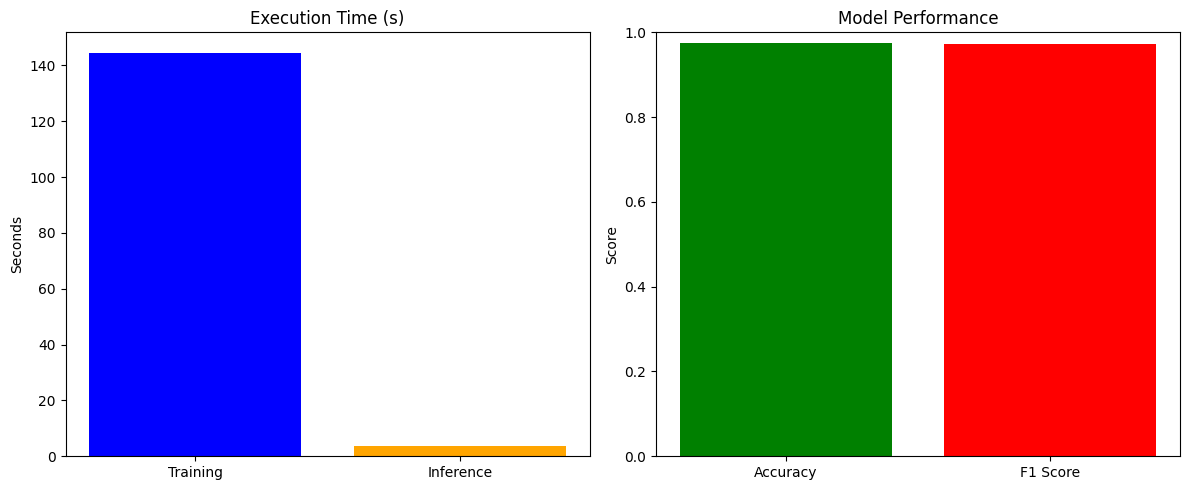

In [ ]:
# Teks Only + Fitur
# ========================== [1] Install Library ==========================
!pip install --upgrade numpy gensim scikit-learn psutil torch torchvision

# ========================== [2] Import Library ==========================
import os, time, random, psutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn, optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from google.colab import drive

# ========================== [3] Seed & Mount ==========================
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
drive.mount('/content/drive')

# ========================== [4] Resource Monitoring & Plotting ==========================
def get_resource_usage():
    process = psutil.Process(os.getpid())
    cpu = psutil.cpu_percent(interval=None)
    ram = process.memory_info().rss / (1024 * 1024)
    return cpu, ram

def plot_execution_summary(log_df):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].bar(["Training", "Inference"],
              [log_df["Training Time (s)"].values[0], log_df["Inference Time (s)"].values[0]],
              color=["blue", "orange"])
    ax[0].set_title("Execution Time (s)")
    ax[0].set_ylabel("Seconds")

    ax[1].bar(["Accuracy", "F1 Score"],
              [log_df["Accuracy"].values[0], log_df["F1 Score"].values[0]],
              color=["green", "red"])
    ax[1].set_ylim(0, 1)
    ax[1].set_title("Model Performance")
    ax[1].set_ylabel("Score")

    plt.tight_layout()
    plt.show()

# ========================== [5] Load Dataset ==========================
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/3. Data Pre Processing/Dataset After Preprocessing/5. Plain Text Only.csv")
df.dropna(subset=["filename", "label", "plain_text_only"], inplace=True)
labels = np.array(df["label"].tolist(), dtype=np.int64)
tokenized_texts = [str(text).split() for text in df["plain_text_only"]]
selected_features = [
    'total_tag','found_keywords', 'total_found_keywords', 'alert_keywords_combo','external_links',
    'js_autoplay_audio','img_tags','css_entropy','html_comment_count',
    'dom_max_depth','visual_density'
]
numeric_features = df[selected_features].fillna(0).values

# ========================== [6] Train-Valid-Test Split ==========================
train_idx, temp_idx, y_train, y_temp = train_test_split(np.arange(len(df)), labels, test_size=0.4, stratify=labels, random_state=seed)
val_idx, test_idx, y_val, y_test = train_test_split(temp_idx, y_temp, test_size=0.5, stratify=y_temp, random_state=seed)
tokenized_texts_train = [tokenized_texts[i] for i in train_idx]
tokenized_texts_val = [tokenized_texts[i] for i in val_idx]
tokenized_texts_test = [tokenized_texts[i] for i in test_idx]

# ========================== [7] Train Word2Vec ==========================
embed_dim = 50
w2v_model = Word2Vec(sentences=tokenized_texts_train, vector_size=embed_dim, window=2, min_count=1, workers=4)

# ========================== [8] Dataset & DataLoader ==========================
class TextDataset(Dataset):
    def __init__(self, tokenized_texts, labels, w2v_model, embed_dim, numeric_features):
        self.texts = tokenized_texts
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.w2v = w2v_model
        self.embed_dim = embed_dim
        self.numeric_features = torch.tensor(numeric_features, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        max_len = 384  # Batasi panjang token di sini
        tokens = self.texts[idx][:max_len]  # Ambil hanya 128 token pertama

        vectors = [
            torch.tensor(self.w2v.wv[word], dtype=torch.float32)
            for word in tokens if word in self.w2v.wv
        ]

        if len(vectors) == 0:
            vectors = [torch.zeros(self.embed_dim, dtype=torch.float32)]

        return torch.stack(vectors), self.numeric_features[idx], self.labels[idx]

def collate_fn(batch):
    sequences, numeric_features, labels = zip(*batch)
    padded = pad_sequence(sequences, batch_first=True)
    numeric_tensor = torch.stack(numeric_features)
    label_tensor = torch.tensor(labels, dtype=torch.long)
    return padded, numeric_tensor, label_tensor

# ========================== [9] Model ==========================
class BiLSTMWithFeatures(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, numeric_dim, dropout=0.3):
        super(BiLSTMWithFeatures, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2 + numeric_dim, output_dim)

    def forward(self, x_seq, x_num):
        lstm_out, (hidden, _) = self.lstm(x_seq)
        hidden_cat = torch.cat((hidden[-2], hidden[-1]), dim=1)
        concat = torch.cat((self.dropout(hidden_cat), x_num), dim=1)
        return self.fc(concat)

def get_model_size(model_path):
    size_bytes = os.path.getsize(model_path)
    size_mb = round(size_bytes / (1024 * 1024), 2)
    return size_mb
# ========================== [10] Loader & Training ==========================
batch_size = 32
train_dataset = TextDataset(tokenized_texts_train, y_train, w2v_model, embed_dim, numeric_features[train_idx])
val_dataset = TextDataset(tokenized_texts_val, y_val, w2v_model, embed_dim, numeric_features[val_idx])
test_dataset = TextDataset(tokenized_texts_test, y_test, w2v_model, embed_dim, numeric_features[test_idx])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

model_path = "/content/drive/My Drive/Colab Notebooks/5. Output/2. Biltstm + Word2Vec/Text Only/best_bilstm.pt"
os.makedirs(os.path.dirname(model_path), exist_ok=True)

model = BiLSTMWithFeatures(embed_dim, hidden_dim=32, output_dim=2, numeric_dim=len(selected_features)).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

retrain = input("Model sudah ada. Ingin melatih ulang? (ya/tidak): ").strip().lower()
start_time = time.time()
cpu_before, ram_before = get_resource_usage()

if os.path.exists(model_path) and retrain != "ya":
    print("✅ Model ditemukan. Melanjutkan ke evaluasi...")
    model.load_state_dict(torch.load(model_path))
else:
    print("🚀 Melatih model dari awal...")
    train_losses, val_losses = [], []
    best_val_loss = float('inf'); wait = 0; patience = 2

    for epoch in range(8):
        model.train()
        total_loss = 0
        for X_seq, X_num, y_batch in train_loader:
            X_seq, X_num, y_batch = X_seq.to(device), X_num.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_seq, X_num)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        val_loss = 0.0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for X_seq, X_num, y_batch in val_loader:
                X_seq, X_num, y_batch = X_seq.to(device), X_num.to(device), y_batch.to(device)
                outputs = model(X_seq, X_num)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y_batch.cpu().numpy())

        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds)
        recall = recall_score(all_labels, all_preds)
        avg_val_loss = val_loss / len(val_loader)
        train_losses.append(total_loss)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}: Train Loss={total_loss:.4f}, Val Loss={avg_val_loss:.4f}, Acc={acc:.4f}, F1={f1:.4f}")
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            wait = 0
            torch.save(model.state_dict(), model_path)
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping")
                break

# ========================== [11] Evaluation ==========================
model.load_state_dict(torch.load(model_path))
model.eval()

# AFTER everything
cpu_after, ram_after = get_resource_usage()
end_time = time.time()

def evaluate_and_plot(loader, name):
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_seq, X_num, y_batch in loader:
            X_seq, X_num, y_batch = X_seq.to(device), X_num.to(device), y_batch.to(device)
            outputs = model(X_seq, X_num)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix\\nAcc: {acc:.4f}, F1: {f1:.4f}")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()
    return acc, f1, precision, recall

evaluate_and_plot(train_loader, "Train")
evaluate_and_plot(val_loader, "Validation")
test_acc, test_f1, test_prec, test_rec = evaluate_and_plot(test_loader, "Test")

# ========================== [12] Logging & Visualisasi Akhir ==========================
start_infer = time.time()
with torch.no_grad():
    for X_seq, X_num, y_batch in test_loader:
        X_seq, X_num, y_batch = X_seq.to(device), X_num.to(device), y_batch.to(device)
        _ = model(X_seq, X_num)
end_infer = time.time()

log_df = pd.DataFrame([{
    "Model": "BiLSTM + Word2Vec (Only Text)",
    "CPU Usage (%)": cpu_after,
    "RAM Usage (MB)": round(ram_after - ram_before, 2),
    "Training Time (s)": round(end_time - start_time, 2),
    "Inference Time (s)": round(end_infer - start_infer, 2),
    "Model Size (MB)": get_model_size(model_path),
    "Accuracy": test_acc,
    "Precision": test_prec,
    "Recall": test_rec,
    "F1 Score": test_f1
}])

log_df.to_csv("/content/drive/My Drive/Colab Notebooks/5. Output/2. Biltstm + Word2Vec/Text Only/resource_log_bilstm.csv", index=False)
display(log_df)  # Fungsi untuk menampilkan dalam tabel jika pakai Google Colab / Jupyter
plot_execution_summary(log_df)
